In [1]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null

!wget -q https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz
!tar xf spark-3.4.1-bin-hadoop3.tgz

!pip install -q findspark
!pip uninstall -y pyspark numpy

!pip install pyspark==3.5.1
!pip install numpy==1.24.4
!pip install --upgrade cloudpickle

Found existing installation: pyspark 3.5.1
Uninstalling pyspark-3.5.1:
  Successfully uninstalled pyspark-3.5.1
Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=97d64f2d696c2939dccd7d723d9c39ccbb0d0d6ac8ad867447f50bc2345dfdf5
  Stored in directory: /root/.cache/pip/wheels/95/13/41/f7f135ee114175605fb4f0a89e7389f3742aa6c1e1a5bcb657
Successfully built pyspark
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 100.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
pymc 5.22.0 requires numpy>

In [ ]:
url = url = "https://static.openfoodfacts.org/data/en.openfoodfacts.org.products.csv"
output_filename = "openfoodfacts_products.csv"

print(f"Téléchargement du fichier CSV depuis {url}...")
!wget -O {output_filename} {url}

Téléchargement du fichier CSV depuis https://static.openfoodfacts.org/data/en.openfoodfacts.org.products.csv...
--2025-06-01 10:02:27--  https://static.openfoodfacts.org/data/en.openfoodfacts.org.products.csv
Resolving static.openfoodfacts.org (static.openfoodfacts.org)... 213.36.253.214
Connecting to static.openfoodfacts.org (static.openfoodfacts.org)|213.36.253.214|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://openfoodfacts-ds.s3.eu-west-3.amazonaws.com/en.openfoodfacts.org.products.csv [following]
--2025-06-01 10:02:28--  https://openfoodfacts-ds.s3.eu-west-3.amazonaws.com/en.openfoodfacts.org.products.csv
Resolving openfoodfacts-ds.s3.eu-west-3.amazonaws.com (openfoodfacts-ds.s3.eu-west-3.amazonaws.com)... 52.95.156.76, 16.12.20.42
Connecting to openfoodfacts-ds.s3.eu-west-3.amazonaws.com (openfoodfacts-ds.s3.eu-west-3.amazonaws.com)|52.95.156.76|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1113605591

In [1]:
import os
import findspark

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"

findspark.init()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, lower, regexp_replace, split, size, isnan, lit, udf
from pyspark.sql.types import DoubleType, BooleanType
from pyspark.ml.feature import VectorAssembler, StandardScaler, Word2Vec, CountVectorizer, Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import json
import re

In [4]:
def clean_missing_values(df):
    print("Nettoyage des valeurs manquantes...")

    print(f"Nombre de lignes avant suppression: {df.count()}")

    df = df.dropna(subset=['product_name', 'brands', 'countries'])

    print(f"Nombre de lignes après suppression: {df.count()}")

    df = df.fillna({
        'categories': 'Unknown',
        'categories_tags': '',
        'ingredients_text': '',
        'countries_tags': '',
        'image_url': '',
        'nutriscore_score': 0
    })

    nutrition_cols = ['energy_100g', 'fat_100g', 'saturated-fat_100g',
                     'carbohydrates_100g', 'sugars_100g', 'proteins_100g',
                     'salt_100g', 'fiber_100g']

    for col in nutrition_cols:
        df = df.fillna({col: 0.0})

    return df

In [5]:
def standardize_units(df):
    print("Standardisation des unités...")

    nutrition_cols = ['energy_100g', 'fat_100g', 'saturated-fat_100g',
                     'carbohydrates_100g', 'sugars_100g', 'proteins_100g',
                     'salt_100g', 'fiber_100g']

    for col_name in nutrition_cols:
        df = df.withColumn(col_name, when(col(col_name) < 0, 0.0).otherwise(col(col_name)))

    return df
def remove_duplicates(df):
    print("Suppression des doublons...")
    initial_count = df.count()
    df = df.dropDuplicates(['code'])
    final_count = df.count()
    print(f"Doublons supprimés: {initial_count - final_count}")
    return df


def detect_anomalies(df):
    print("Détection des anomalies...")

    df = df.withColumn('energy_100g',
                      when(col('energy_100g') > 3000, 900.0)
                      .otherwise(col('energy_100g')))

    df = df.withColumn('sugars_100g',
                      when(col('sugars_100g') > col('carbohydrates_100g'),
                           col('carbohydrates_100g'))
                      .otherwise(col('sugars_100g')))

    return df

In [6]:
def parse_ingredients(df):
    print("Parsing des ingrédients...")

    df = df.withColumn('ingredients_clean',
                      lower(regexp_replace(col('ingredients_text'), '[^a-zA-Z0-9 ,]', '')))\
           .fillna({'ingredients_clean': ''})

    df = df.withColumn('ingredients_list', split(col('ingredients_clean'), ','))

    df = df.withColumn('ingredients_count', size(col('ingredients_list')))

    return df

def compute_nutritional_features(df):
    print("Calcul des caractéristiques nutritionnelles...")

    df = df.withColumn('protein_energy_ratio',
                      when(col('energy_100g') > 0,
                           col('proteins_100g') / col('energy_100g') * 100)
                      .otherwise(0))

    df = df.withColumn('nutrient_density',
                      when(col('energy_100g') > 0,
                           (col('proteins_100g') + col('fiber_100g')) / col('energy_100g') * 100)
                      .otherwise(0))

    df = df.withColumn('nutrition_quality_score',
                      col('proteins_100g') + col('fiber_100g') -
                      col('saturated-fat_100g') - col('sugars_100g') - col('salt_100g'))

    return df

def create_category_features(df):
    print("Création des features de catégories...")

    df = df.withColumn('categories_list', split(lower(col('categories')), ','))
    df = df.withColumn('categories_count', size(col('categories_list')))\
           .withColumn('categories_count', when(col('categories') == 'Unknown', 0).otherwise(col('categories_count'))) # Set count to 0 if category is 'Unknown'

    main_categories = ['dairy', 'meat', 'vegetables', 'fruits', 'cereals', 'beverages']

    for category in main_categories:
        df = df.withColumn(f'is_{category}',
                          when(lower(col('categories')).contains(category), 1).otherwise(0))

    return df

In [7]:
def perform_eda(df):
    print("\n=== ANALYSE EXPLORATOIRE DES DONNÉES ===")

    pandas_df = df.limit(10000).toPandas()

    print("\n--- Statistiques descriptives ---")
    nutrition_cols = ['energy_100g', 'fat_100g', 'carbohydrates_100g', 'proteins_100g']
    print(pandas_df[nutrition_cols].describe())

    print("\n--- Distribution Nutri-Score ---")
    nutriscore_dist = pandas_df['nutriscore_grade'].value_counts()
    print(nutriscore_dist)

    print("\n--- Corrélations nutritionnelles ---")
    corr_matrix = pandas_df[nutrition_cols].corr()
    print(corr_matrix)

    return pandas_df

In [8]:
def visualize_data(pandas_df):
    print("Création des visualisations...")

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    axes[0,0].hist(pandas_df['energy_100g'], bins=30, alpha=0.7)
    axes[0,0].set_title("Distribution de l'énergie (kJ/100g)")
    axes[0,0].set_xlabel('Énergie')
    axes[0,0].set_ylabel('Fréquence')

    axes[0,1].hist(pandas_df['proteins_100g'], bins=30, alpha=0.7, color='green')
    axes[0,1].set_title('Distribution des protéines (g/100g)')
    axes[0,1].set_xlabel('Protéines')
    axes[0,1].set_ylabel('Fréquence')

    nutriscore_counts = pandas_df['nutriscore_grade'].value_counts()
    axes[1,0].bar(nutriscore_counts.index, nutriscore_counts.values)
    axes[1,0].set_title('Distribution Nutri-Score')
    axes[1,0].set_xlabel('Grade')
    axes[1,0].set_ylabel('Nombre de produits')

    axes[1,1].scatter(pandas_df['energy_100g'], pandas_df['proteins_100g'], alpha=0.6)
    axes[1,1].set_title('Énergie vs Protéines')
    axes[1,1].set_xlabel('Énergie (kJ/100g)')
    axes[1,1].set_ylabel('Protéines (g/100g)')

    plt.tight_layout()
    plt.show()

In [9]:
def vectorize_ingredients(df):
    print("Vectorisation des ingrédients avec PySpark MLlib...")

    tokenizer = Tokenizer(inputCol="ingredients_clean", outputCol="words")
    words_data = tokenizer.transform(df)

    remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
    words_data = remover.transform(words_data)
    input_col_for_hashing = "filtered_words"

    num_features_chosen = 2000

    hashingTF = HashingTF(inputCol=input_col_for_hashing, outputCol="raw_features", numFeatures=num_features_chosen)
    featurized_data = hashingTF.transform(words_data)

    idf = IDF(inputCol="raw_features", outputCol="ingredient_vectors")
    idf_model = idf.fit(featurized_data)
    rescaled_data = idf_model.transform(featurized_data)

    return rescaled_data, idf_model, num_features_chosen

In [10]:
def create_nutrition_vectors(df):
    print("Création des vecteurs nutritionnels...")

    nutrition_cols = ['energy_100g', 'fat_100g', 'carbohydrates_100g',
                     'proteins_100g', 'salt_100g', 'fiber_100g', 'sugars_100g', 'saturated-fat_100g']

    assembler = VectorAssembler(inputCols=nutrition_cols, outputCol="nutrition_features")
    df_features = assembler.transform(df)

    scaler = StandardScaler(inputCol="nutrition_features", outputCol="nutrition_vectors",
                           withStd=True, withMean=True)
    scaler_model = scaler.fit(df_features)
    df_scaled = scaler_model.transform(df_features)

    return df_scaled, scaler_model

In [11]:
def create_recommender_system(spark_session, df_products_vectorized, tfidf_model, scaler_model, num_features_for_ingredients):
    print("Création du système de recommandation...")

    @udf(DoubleType())
    def cosine_similarity_udf(vec1, vec2):
        if vec1 is None or vec2 is None:
            return 0.0
        if vec1.size != vec2.size:
            print(f"Warning: Vector dimension mismatch. vec1 size: {vec1.size}, vec2 size: {vec2.size}")
            return 0.0

        dot_product = float(vec1.dot(vec2))
        norm_vec1 = float(vec1.norm(2))
        norm_vec2 = float(vec2.norm(2))

        norm_product = norm_vec1 * norm_vec2
        if norm_product == 0:
            return 0.0
        return dot_product / norm_product

    def get_recommendations(user_recipe, country=None, nutriscore_filter=None,
                          allergen_exclusions=None, top_k=10):
        print(f"Generating recommendations for: '{user_recipe}'")

        user_recipe_clean_str = re.sub(r'[^a-zA-Z0-9 ,]', '', user_recipe).lower()

        user_df_spark = spark_session.createDataFrame([(user_recipe_clean_str,)], ["ingredients_clean"])

        tokenizer = Tokenizer(inputCol="ingredients_clean", outputCol="words")
        user_words_data = tokenizer.transform(user_df_spark)

        remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
        user_filtered_words = remover.transform(user_words_data)

        hashingTF_user = HashingTF(inputCol="filtered_words", outputCol="raw_features", numFeatures=num_features_for_ingredients)
        user_raw_features = hashingTF_user.transform(user_filtered_words)

        user_ingredient_vector_df = tfidf_model.transform(user_raw_features).select('ingredient_vectors')

        user_ingredient_vector_list = user_ingredient_vector_df.limit(1).collect()
        user_ingredient_vector = None
        if user_ingredient_vector_list:
            user_ingredient_vector = user_ingredient_vector_list[0].ingredient_vectors

        if user_ingredient_vector is None:
            user_ingredient_vector = Vectors.sparse(num_features_for_ingredients, [])
            print("Warning: User ingredient vector is empty or could not be generated. Using a sparse zero vector.")

        nutrition_features_length = len(scaler_model.mean)
        user_nutrition_vector = Vectors.dense([0.0] * nutrition_features_length)

        broadcast_ingredient_vector = spark_session.sparkContext.broadcast(user_ingredient_vector)
        broadcast_nutrition_vector = spark_session.sparkContext.broadcast(user_nutrition_vector)

        @udf(DoubleType())
        def ingredient_similarity_udf(product_vector):
            if product_vector is None:
                return 0.0
            user_vec = broadcast_ingredient_vector.value
            if user_vec is None or product_vector.size != user_vec.size:
                return 0.0

            dot_product = float(product_vector.dot(user_vec))
            norm_product = float(product_vector.norm(2)) * float(user_vec.norm(2))
            if norm_product == 0:
                return 0.0
            return dot_product / norm_product

        @udf(DoubleType())
        def nutrition_similarity_udf(product_vector):
            if product_vector is None:
                return 0.0
            user_vec = broadcast_nutrition_vector.value
            if user_vec is None or product_vector.size != user_vec.size:
                return 0.0

            dot_product = float(product_vector.dot(user_vec))
            norm_product = float(product_vector.norm(2)) * float(user_vec.norm(2))
            if norm_product == 0:
                return 0.0
            return dot_product / norm_product

        df_ranked = df_products_vectorized.withColumn(
            "ingredient_similarity",
            ingredient_similarity_udf(col("ingredient_vectors"))
        ).withColumn(
            "nutrition_similarity",
            nutrition_similarity_udf(col("nutrition_vectors"))
        ).withColumn(
            "combined_similarity_score",
            (lit(0.6) * col("nutrition_similarity")) + (lit(0.4) * col("ingredient_similarity"))
        )

        if country:
            df_ranked = df_ranked.filter(lower(col('countries')).contains(lower(lit(country))))

        if nutriscore_filter:
            if isinstance(nutriscore_filter, str):
                nutriscore_filter = [nutriscore_filter]
            nutriscore_filter_lower = [g.lower() for g in nutriscore_filter]
            df_ranked = df_ranked.filter(lower(col('nutriscore_grade')).isin(nutriscore_filter_lower))

        final_recommendations_spark = df_ranked.orderBy(col("combined_similarity_score").desc()).limit(top_k)

        result_df = final_recommendations_spark.select(
            'product_name', 'categories', 'nutriscore_grade',
            'combined_similarity_score', 'countries', 'brands', 'image_url'
        ).toPandas()

        broadcast_ingredient_vector.unpersist()
        broadcast_nutrition_vector.unpersist()

        return result_df

    return get_recommendations

In [12]:
    print("=== DÉMARRAGE DU PIPELINE OPEN FOOD FACTS ===\n")

    spark = SparkSession.builder \
        .appName("OpenFoodFacts Recommendation System") \
        .config("spark.sql.adaptive.enabled", "true") \
        .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
        .config("spark.driver.memory", "4g") \
        .config("spark.executor.memory", "4g") \
        .config("spark.executor.instances", "1") \
        .config("spark.executor.cores", "2")   \
        .config("spark.driver.maxResultSize", "2g") \
        .config("spark.rpc.message.maxSize", "512") \
        .config("spark.network.timeout", "300s") \
        .config("spark.driver.host", "127.0.0.1") \
        .config("spark.driver.port", "0") \
        .config("spark.blockManager.port", "0") \
        .getOrCreate()

    df_raw = spark.read.csv(
        r"/content/drive/MyDrive/openfoodfacts_products.csv",
        sep="\t",
        header=True,
        inferSchema=True,
        mode="DROPMALFORMED"
    )

    print("=== DONNÉES ORIGINALES ===")
    total_rows = df_raw.count()
    total_cols = len(df_raw.columns)
    print(f"Nombre de lignes: {total_rows:,}")
    print(f"Nombre de colonnes: {total_cols}")
    df_raw.show(5)

=== DÉMARRAGE DU PIPELINE OPEN FOOD FACTS ===

=== DONNÉES ORIGINALES ===
Nombre de lignes: 3,871,738
Nombre de colonnes: 209
+-----+--------------------+-------+----------+-------------------+---------------+----------------------+----------------+--------------+---------------------+--------------------+------------------------+------------+------------------+---------+--------------+------------+--------------+--------------+-----------------+--------------+--------------------+--------------------+--------------------+-------+------------+----------+--------------------+-------------------------+--------------------+--------------------+--------------------+---------+--------------+------------------------+------+-----------+---------------+------+----------------+-------------------+-------------+--------------------+--------------------+-------------------------+---------+------------+------+-----------+---------+------------+----------------+-----------------+-----------+-------

In [18]:
    colonnes_utiles = ["code", "product_name", "brands", "countries", "countries_tags",
        "ingredients_text", "categories", "categories_tags","image_url",
        "nutriscore_score", "energy_100g", "proteins_100g",
        "carbohydrates_100g", "fat_100g", "salt_100g", "fiber_100g", "sugars_100g", "nutriscore_grade", "saturated-fat_100g"]
    df_raw = df_raw.select(*colonnes_utiles)

    print("\n2. NETTOYAGE DES DONNÉES")
    df_clean = clean_missing_values(df_raw)
    df_clean = standardize_units(df_clean)
    df_clean = remove_duplicates(df_clean)
    df_clean = detect_anomalies(df_clean)

    print("\n3. INGÉNIERIE DES CARACTÉRISTIQUES")
    df_features = parse_ingredients(df_clean)
    df_features = compute_nutritional_features(df_features)
    df_features = create_category_features(df_features)

    print(f"Count of df_features after feature engineering: {df_features.count():,}")
    df_features.printSchema()

    problematic_cols = ['protein_energy_ratio', 'nutrient_density']
    for col_name in problematic_cols:
        if col_name in df_features.columns:
            invalid_count = df_features.filter(isnan(col(col_name))).count()
            if invalid_count > 0:
                print(f"Warning: Column '{col_name}' contains {invalid_count} invalid (NaN/Inf) values.")
                df_features = df_features.withColumn(col_name,
                                                     when(isnan(col(col_name)) , lit(0.0))
                                                     .otherwise(col(col_name)))
                print(f"Note: Invalid values in '{col_name}' have been replaced with 0.0.")

    print("Échantillon des données après feature engineering:")
    df_features.select('product_name', 'ingredients_count', 'protein_energy_ratio',
                       'nutrient_density').show()


2. NETTOYAGE DES DONNÉES
Nettoyage des valeurs manquantes...
Nombre de lignes avant suppression: 3871738
Nombre de lignes après suppression: 2265241
Standardisation des unités...
Suppression des doublons...
Doublons supprimés: 3367
Détection des anomalies...

3. INGÉNIERIE DES CARACTÉRISTIQUES
Parsing des ingrédients...
Calcul des caractéristiques nutritionnelles...
Création des features de catégories...
Count of df_features after feature engineering: 2,261,874
root
 |-- code: double (nullable = true)
 |-- product_name: string (nullable = true)
 |-- brands: string (nullable = true)
 |-- countries: string (nullable = true)
 |-- countries_tags: string (nullable = false)
 |-- ingredients_text: string (nullable = false)
 |-- categories: string (nullable = false)
 |-- categories_tags: string (nullable = false)
 |-- image_url: string (nullable = false)
 |-- nutriscore_score: integer (nullable = false)
 |-- energy_100g: double (nullable = false)
 |-- proteins_100g: double (nullable = false)



📊 ANALYSE DES PAYS ET MARQUES


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127991 (\N{LABEL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


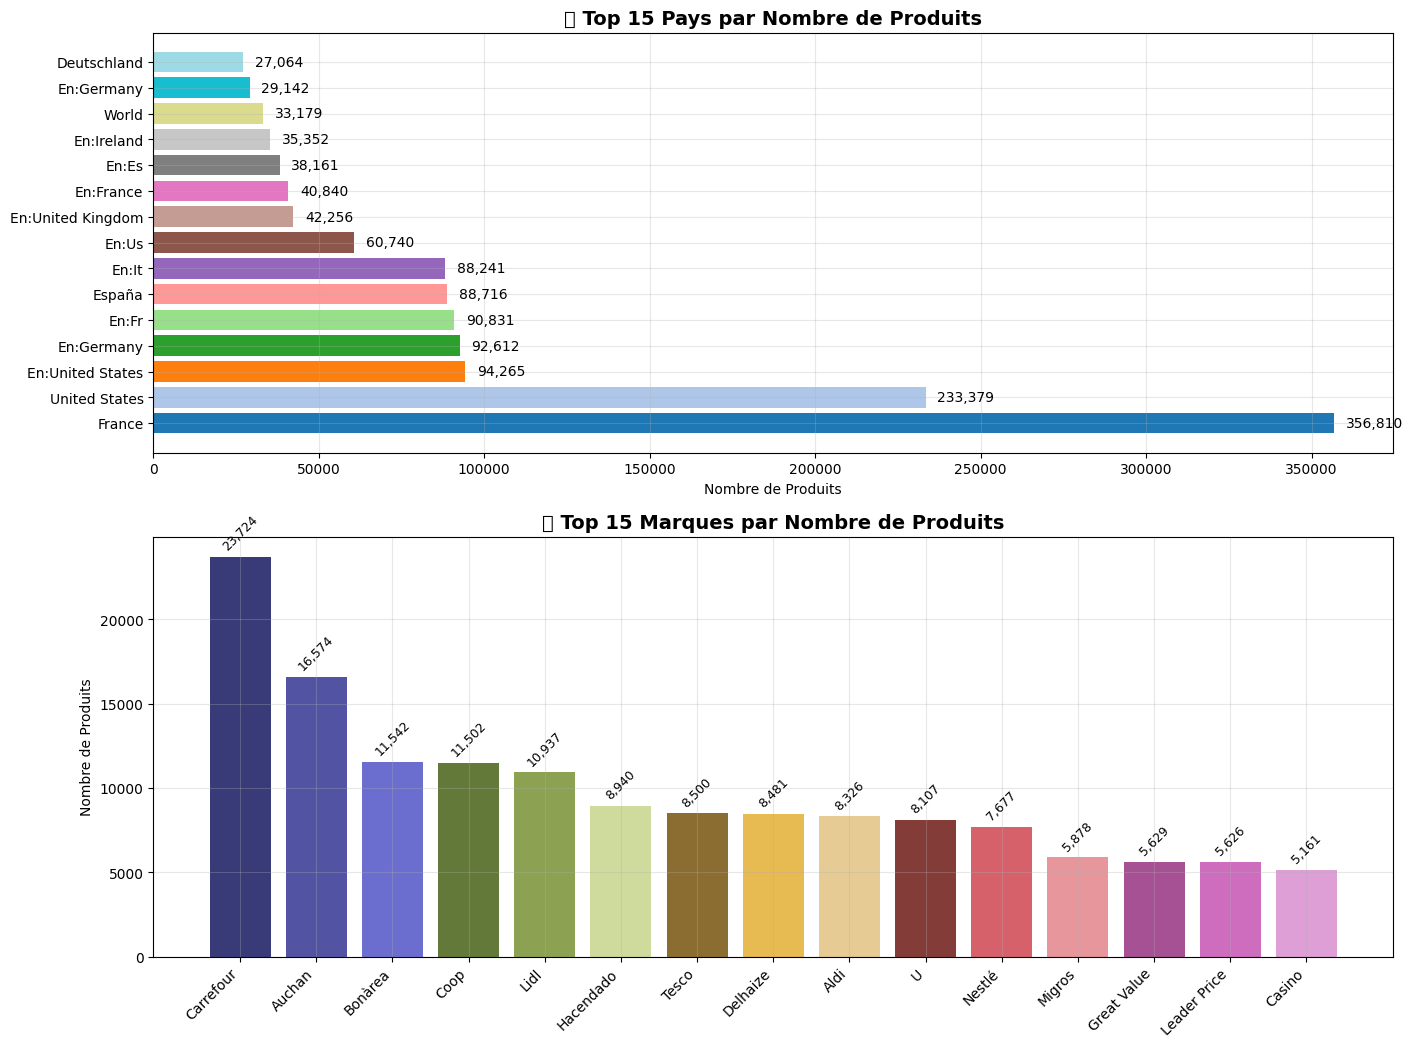

In [19]:
def visualize_countries_brands_v2():
    print("\n  ANALYSE DES PAYS ET MARQUES")

    countries_data = df_clean.select("countries") \
        .filter(col("countries") != "unknown") \
        .groupBy("countries") \
        .count() \
        .orderBy(col("count").desc()) \
        .limit(15) \
        .toPandas()

    brands_data = df_clean.select("brands") \
        .filter(col("brands") != "") \
        .groupBy("brands") \
        .count() \
        .orderBy(col("count").desc()) \
        .limit(15) \
        .toPandas()

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

    bars1 = ax1.barh(range(len(countries_data)), countries_data['count'],
                     color=plt.cm.tab20(np.linspace(0, 1, len(countries_data))))
    ax1.set_yticks(range(len(countries_data)))
    ax1.set_yticklabels(countries_data['countries'].str.title())
    ax1.set_title('🌍 Top 15 Pays par Nombre de Produits', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Nombre de Produits')
    ax1.grid(True, alpha=0.3)

    countries_max = countries_data['count'].iloc[0]
    for i, (idx, row) in enumerate(countries_data.iterrows()):
        count_val = row['count']
        bar = bars1[i]
        ax1.text(count_val + countries_max*0.01, bar.get_y() + bar.get_height()/2,
                f'{int(count_val):,}', ha='left', va='center', fontsize=10)

    bars2 = ax2.bar(range(len(brands_data)), brands_data['count'],
                    color=plt.cm.tab20b(np.linspace(0, 1, len(brands_data))))
    ax2.set_xticks(range(len(brands_data)))
    ax2.set_xticklabels(brands_data['brands'].str.title(), rotation=45, ha='right')
    ax2.set_title('🏷 Top 15 Marques par Nombre de Produits', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Nombre de Produits')
    ax2.grid(True, alpha=0.3)

    brands_max = brands_data['count'].iloc[0]
    for i, (idx, row) in enumerate(brands_data.iterrows()):
        count_val = row['count']
        bar = bars2[i]
        ax2.text(bar.get_x() + bar.get_width()/2, count_val + brands_max*0.01,
                f'{int(count_val):,}', ha='center', va='bottom', fontsize=9, rotation=45)

    plt.show()

visualize_countries_brands_v2()


 Top 15 des catégories de produits


<ipython-input-14-ee747360707f>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='category', data=categories_data, palette='viridis')


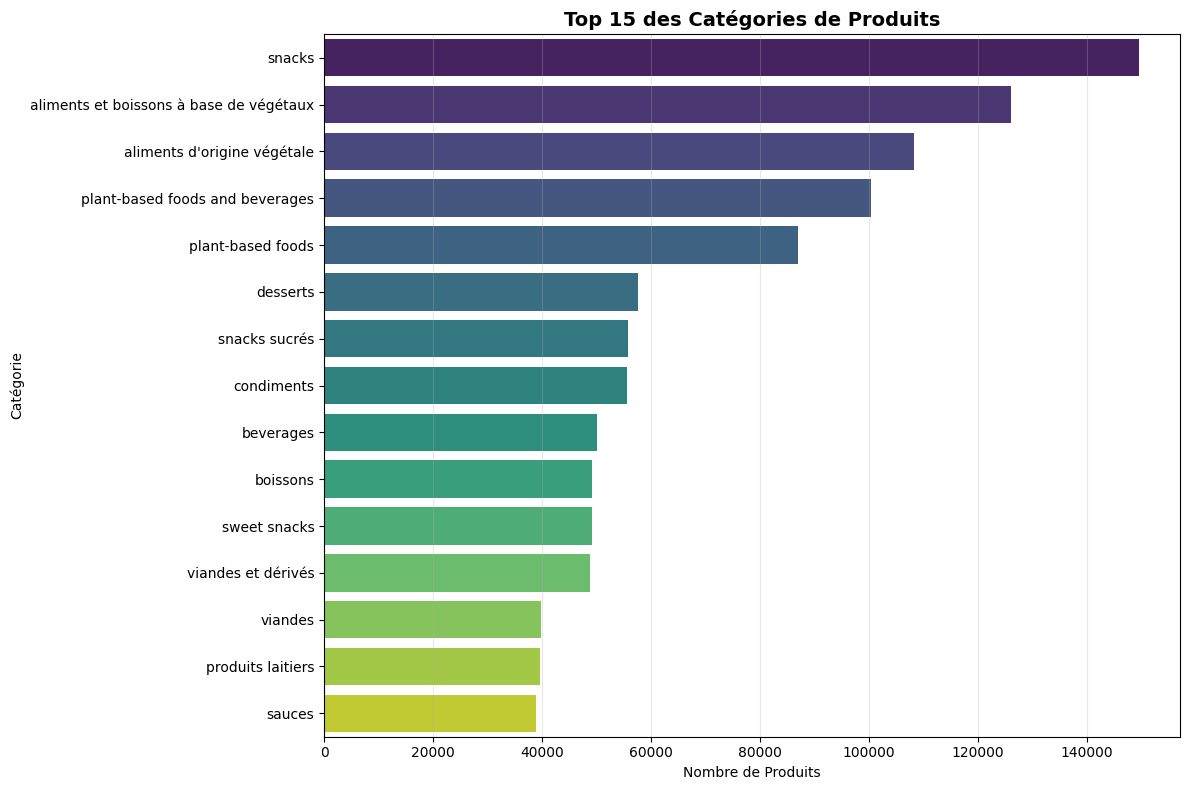

In [14]:
from pyspark.sql.functions import col, explode, lower, trim

print("\n Top 15 des catégories de produits")

categories_data = df_features.select(explode(col("categories_list")).alias("category")) \
    .withColumn("category", trim(lower(col("category")))) \
    .filter((col("category") != "") & (col("category") != "unknown")) \
    .groupBy("category") \
    .count() \
    .orderBy(col("count").desc()) \
    .limit(15) \
    .toPandas()

if not categories_data.empty:
    plt.figure(figsize=(12, 8))
    sns.barplot(x='count', y='category', data=categories_data, palette='viridis')
    plt.title('Top 15 des Catégories de Produits', fontsize=14, fontweight='bold')
    plt.xlabel('Nombre de Produits')
    plt.ylabel('Catégorie')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Aucune donnée disponible pour tracer les catégories principales.")


 Box Plot du Nombre d'Ingrédients par Nutri-Score Grade


<ipython-input-19-4ed2dbccadb4>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='nutriscore_grade', y='ingredients_count', data=ingredients_nutriscore_df, palette='cubehelix', order=['a', 'b', 'c', 'd', 'e'])


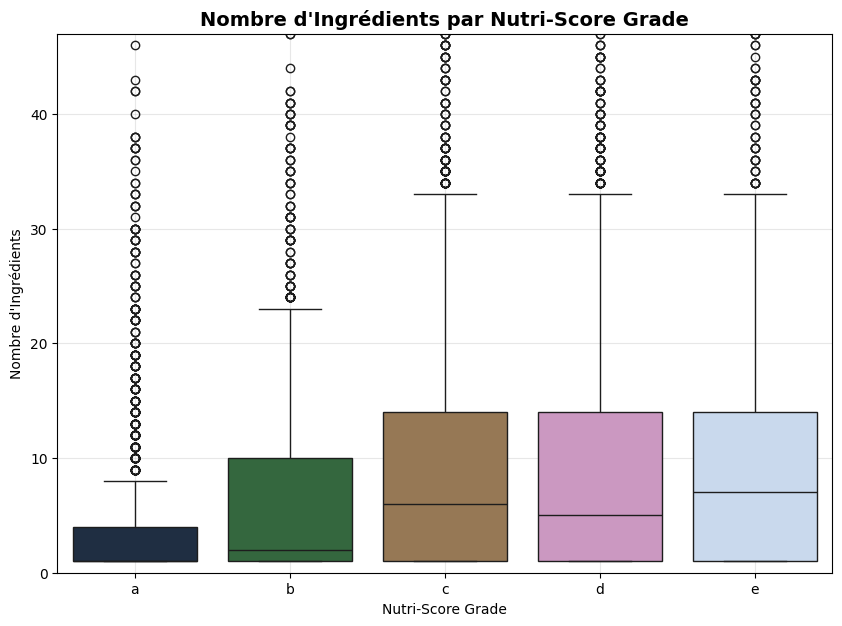

In [19]:
print("\n Box Plot du Nombre d'Ingrédients par Nutri-Score Grade")

if "ingredients_count" in df_features.columns and "nutriscore_grade" in df_clean.columns:
    ingredients_nutriscore_df = df_features.select("ingredients_count", "nutriscore_grade") \
                                           .filter(col('nutriscore_grade').isin(['a', 'b', 'c', 'd', 'e'])) \
                                           .filter(col("ingredients_count").isNotNull()) \
                                           .limit(10000).toPandas()

    if not ingredients_nutriscore_df.empty:
        plt.figure(figsize=(10, 7))
        sns.boxplot(x='nutriscore_grade', y='ingredients_count', data=ingredients_nutriscore_df, palette='cubehelix', order=['a', 'b', 'c', 'd', 'e'])
        plt.title("Nombre d'Ingrédients par Nutri-Score Grade", fontsize=14, fontweight='bold')
        plt.xlabel('Nutri-Score Grade')
        plt.ylabel("Nombre d'Ingrédients")
        plt.ylim(0, ingredients_nutriscore_df['ingredients_count'].quantile(0.99))
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        print("Pas de données suffisantes pour le box plot (ingredients_count, nutriscore_grade).")
else:
    print("Les colonnes requises ne sont pas disponibles pour cette visualisation.")


 Carte de chaleur des corrélations des principales caractéristiques nutritionnelles


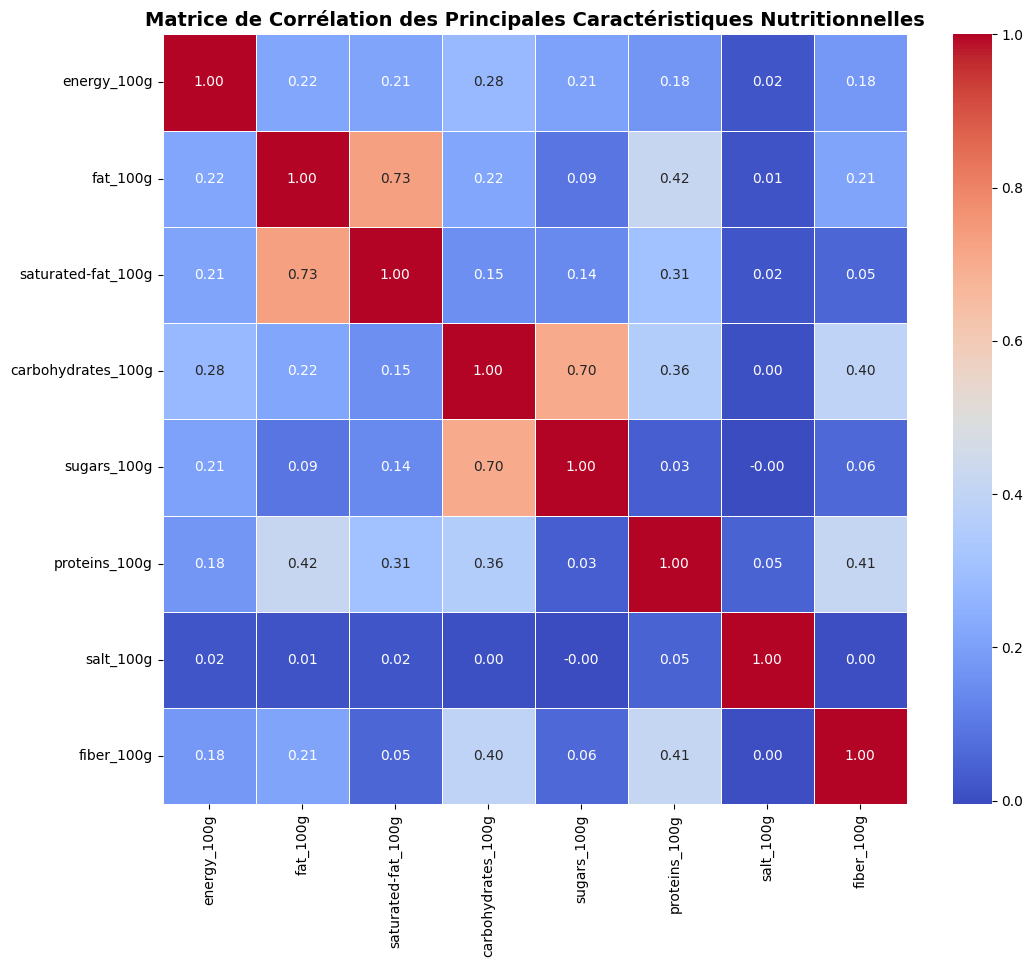

In [20]:
print("\n Carte de chaleur des corrélations des principales caractéristiques nutritionnelles")

nutrition_cols_for_corr = ['energy_100g', 'fat_100g', 'saturated-fat_100g',
                           'carbohydrates_100g', 'sugars_100g', 'proteins_100g',
                           'salt_100g', 'fiber_100g']

corr_df_spark = df_features.select(nutrition_cols_for_corr).na.drop().limit(10000)
corr_pandas_df = corr_df_spark.toPandas()

if not corr_pandas_df.empty:
    corr_matrix = corr_pandas_df.corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Matrice de Corrélation des Principales Caractéristiques Nutritionnelles', fontsize=14, fontweight='bold')
    plt.show()
else:
    print("Pas de données suffisantes pour la carte de chaleur des corrélations après suppression des nulles ou l'échantillon est vide.")



=== ANALYSE EXPLORATOIRE DES DONNÉES ===

--- Statistiques descriptives ---
         energy_100g     fat_100g  carbohydrates_100g  proteins_100g
count    5508.000000  5260.000000         5381.000000    5286.000000
mean     1238.425034    13.469445           30.818477      15.757568
std      2163.622450    22.474218           51.355308      47.531151
min         0.000000     0.000000            0.000000       0.000000
25%       460.000000     1.500000            6.666667       2.359706
50%      1172.000000     7.295000           19.000000       7.500000
75%      1691.000000    18.799999           47.900000      19.000000
max    101000.000000   700.000000         2200.000000    1800.000000

--- Distribution Nutri-Score ---
nutriscore_grade
unknown           8371
e                  373
d                  291
not-applicable     247
a                  235
c                  227
b                  100
Name: count, dtype: int64

--- Corrélations nutritionnelles ---
                    energy

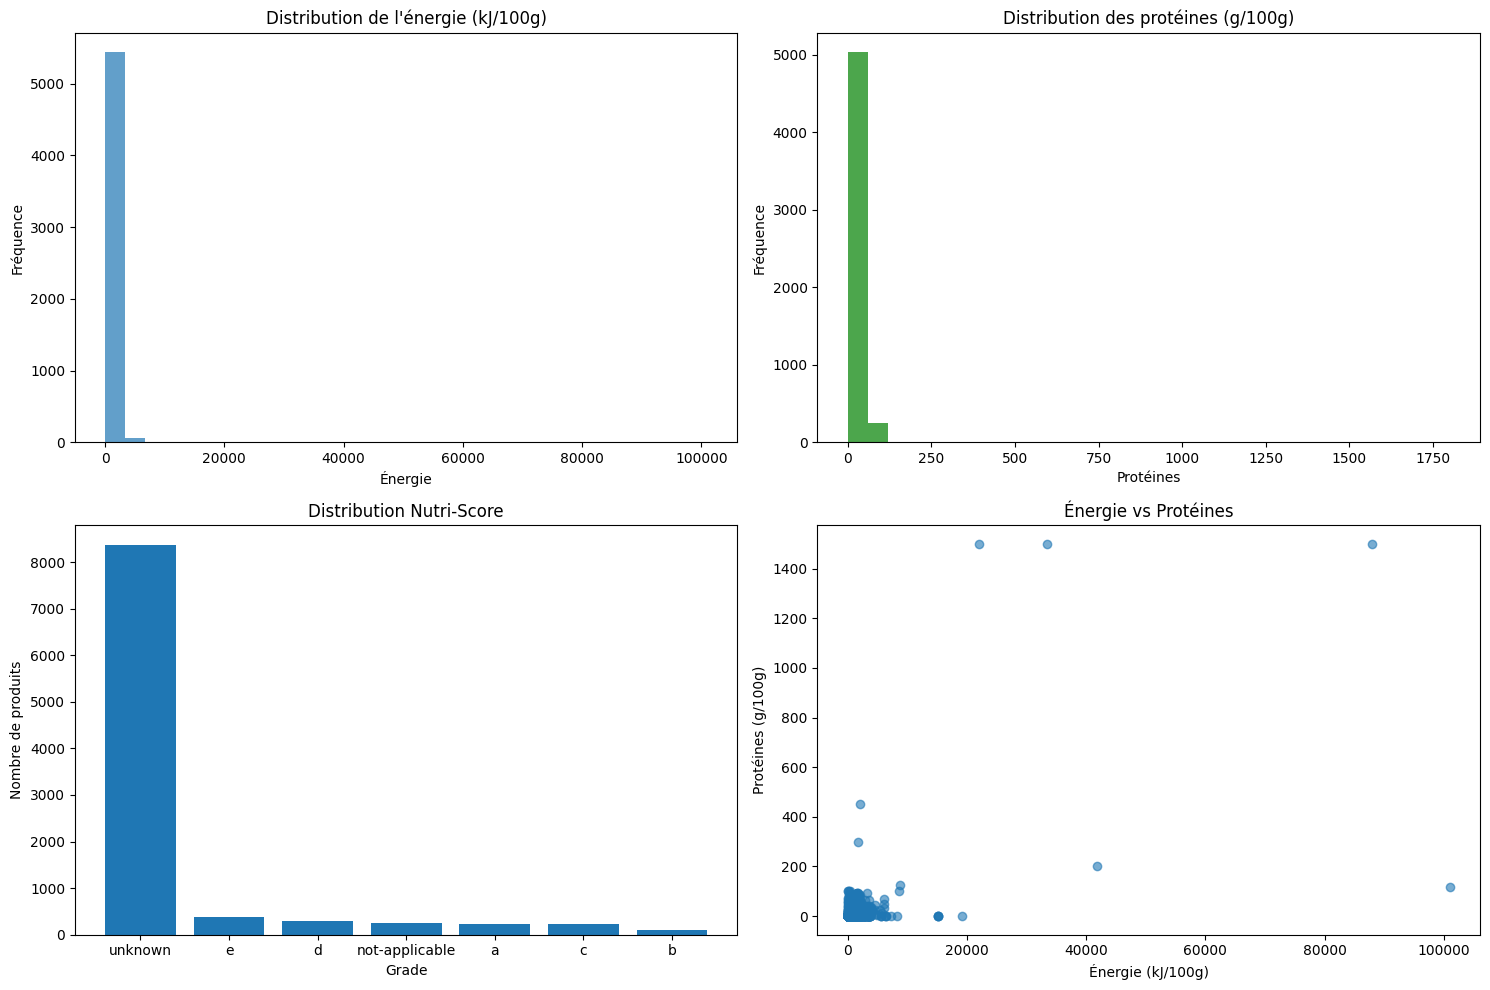

In [15]:
pandas= perform_eda(df_raw)
visualize_data(pandas)

In [20]:
    print("\n5. VECTORISATION")
    df_for_vectorization = df_features.filter(col('ingredients_clean').isNotNull())
    df_ingredients_vectorized, tfidf_model, num_features_for_ingredients = vectorize_ingredients(df_for_vectorization)

    df_products_vectorized, scaler_model = create_nutrition_vectors(df_ingredients_vectorized)

    print("\n6. SYSTÈME DE RECOMMANDATION")
    recommender = create_recommender_system(spark, df_products_vectorized, tfidf_model, scaler_model, num_features_for_ingredients)



5. VECTORISATION
Vectorisation des ingrédients avec PySpark MLlib...
Création des vecteurs nutritionnels...

6. SYSTÈME DE RECOMMANDATION
Création du système de recommandation...


In [23]:
    test_cases = [
        {
            'name': 'Recette de salade',
            'recipe': 'salade verte, tomates, vinaigrette',
            'allergen_exclusions': ['gluten']
        },
        {
            'name': 'Recette avec poisson',
            'recipe': 'saumon, légumes, huile olive',
            'country': 'France'
        }
    ]

    print("\n8. TESTS DU SYSTÈME DE RECOMMANDATION")
    for i, test_case in enumerate(test_cases, 1):
        try:
            print(f"\n--- Test Case {i}: {test_case['name']} ---")
            print(f"Recette: {test_case['recipe']}")

            recipe = test_case['recipe']
            country = test_case.get('country', None)
            nutriscore_filter = test_case.get('nutriscore_filter', None)
            allergen_exclusions = test_case.get('allergen_exclusions', None)

            recommendations = recommender(
                user_recipe=recipe,
                country=country,
                nutriscore_filter=nutriscore_filter,
                allergen_exclusions=allergen_exclusions,
                top_k=5
            )

            print(f"Nombre de recommandations trouvées: {len(recommendations)}")
            if len(recommendations) > 0:
                print("Top 3 recommandations:")
                for idx, row in recommendations.head(3).iterrows():
                    print(f"  {idx+1}. {row['product_name']} (Score: {row['combined_similarity_score']:.3f})")
            else:
                print("Aucune recommandation trouvée pour ce test case.")

        except Exception as e:
            print(f"Erreur lors de la génération des recommandations: {str(e)}")
            import traceback
            traceback.print_exc()

    print("\n=== PIPELINE TERMINÉ AVEC SUCCÈS ===")


8. TESTS DU SYSTÈME DE RECOMMANDATION

--- Test Case 1: Recette de salade ---
Recette: salade verte, tomates, vinaigrette
Generating recommendations for: 'salade verte, tomates, vinaigrette'
Nombre de recommandations trouvées: 5
Top 3 recommandations:
  1. Neitsytkookosöljy (Score: 0.235)
  2. Lard (Score: 0.209)
  3. Mushrooms (Score: 0.203)

--- Test Case 2: Recette avec poisson ---
Recette: saumon, légumes, huile olive
Generating recommendations for: 'saumon, légumes, huile olive'
Nombre de recommandations trouvées: 5
Top 3 recommandations:
  1. lou premier rai (Score: 0.260)
  2. saumon fumé 5 baies 6 tranches (Score: 0.219)
  3. Olio Extra Vergine di Oliva TerrAnima (Score: 0.216)

=== PIPELINE TERMINÉ AVEC SUCCÈS ===


In [22]:
import pickle
import joblib
from pyspark.ml import Pipeline
from pyspark.ml.feature import IDFModel, StandardScalerModel
import os
import time

def save_recommender_system_robust(spark, df_products_vectorized, tfidf_model, scaler_model,
                                 num_features_for_ingredients, base_path):

    print("Sauvegarde robuste du système de recommandation...")

    os.makedirs(base_path, exist_ok=True)

    success_steps = []

    try:
        print("1. Sauvegarde des modèles ML...")

        tfidf_path = f"{base_path}tfidf_model"
        try:
            if os.path.exists(tfidf_path):
                import shutil
                shutil.rmtree(tfidf_path)
            tfidf_model.write().overwrite().save(tfidf_path)
            success_steps.append("tfidf_model")
            print("    Modèle TF-IDF sauvegardé")
        except Exception as e:
            print(f"    Erreur TF-IDF: {e}")

        scaler_path = f"{base_path}scaler_model"
        try:
            if os.path.exists(scaler_path):
                import shutil
                shutil.rmtree(scaler_path)
            scaler_model.write().overwrite().save(scaler_path)
            success_steps.append("scaler_model")
            print("    Modèle Scaler sauvegardé")
        except Exception as e:
            print(f"    Erreur Scaler: {e}")

        print("2. Sauvegarde du DataFrame vectorisé...")
        df_saved = False

        try:
            df_path = f"{base_path}df_products_vectorized"
            if os.path.exists(df_path):
                import shutil
                shutil.rmtree(df_path)

            df_coalesced = df_products_vectorized.coalesce(1)
            df_coalesced.write.mode("overwrite").parquet(df_path)
            success_steps.append("dataframe_parquet")
            df_saved = True
            print("   ✅ DataFrame sauvegardé en Parquet")
        except Exception as e:
            print(f"   ⚠️ Erreur Parquet: {e}")

        print("3. Sauvegarde des métadonnées...")
        try:
            metadata = {
                'num_features_for_ingredients': num_features_for_ingredients,
                'spark_version': spark.version,
                'timestamp': str(time.time()),
                'success_steps': success_steps,
                'total_products': df_products_vectorized.count() if df_saved else "unknown"
            }

            with open(f"{base_path}metadata.pickle", 'wb') as f:
                pickle.dump(metadata, f)
            success_steps.append("metadata")
            print("   ✅ Métadonnées sauvegardées")
        except Exception as e:
            print(f"   ❌ Erreur métadonnées: {e}")

        print(f"\n📊 RÉSUMÉ DE LA SAUVEGARDE:")
        print(f"✅ Étapes réussies: {len(success_steps)}")
        print(f"📁 Dossier: {base_path}")
        for step in success_steps:
            print(f"   ✓ {step}")

        return len(success_steps) > 0, success_steps

    except Exception as e:
        print(f"❌ Erreur générale: {e}")
        return False, success_steps

gdrive_path = "/content/drive/MyDrive/recommender_system/"
success, steps = save_recommender_system_robust(
    spark=spark,
    df_products_vectorized=df_products_vectorized,
    tfidf_model=tfidf_model,
    scaler_model=scaler_model,
    num_features_for_ingredients=num_features_for_ingredients,
    base_path=gdrive_path
)

if success:
    print("✅ Sauvegarde terminée avec succès!")
else:
    print("❌ Sauvegarde échouée - vérifiez les erreurs ci-dessus")

Sauvegarde robuste du système de recommandation...
1. Sauvegarde des modèles ML...
   ✅ Modèle TF-IDF sauvegardé
   ✅ Modèle Scaler sauvegardé
2. Sauvegarde du DataFrame vectorisé...
   ✅ DataFrame sauvegardé en Parquet
3. Sauvegarde des métadonnées...
   ✅ Métadonnées sauvegardées

📊 RÉSUMÉ DE LA SAUVEGARDE:
✅ Étapes réussies: 4
📁 Dossier: /content/drive/MyDrive/recommender_system/
   ✓ tfidf_model
   ✓ scaler_model
   ✓ dataframe_parquet
   ✓ metadata
✅ Sauvegarde terminée avec succès!
